## Case 4

In this case study, we deal with **every 15 minutes prediction**. We will use 3 types of deep learning models to forecast an ICU adult patient's blood culture test results.
Input

> * ICU adults' vital signs and lab results in minutes

Output 

> * 3 categories of blood culture status -- positive / negative / no blood culture
> * label : positive VS negative + no blood culture

Classification strategy
> * summarize/use a certain length of per-minute inputs to every 15 minutes record since admission
> * train, test datasets split by subject

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import FAIRStream

## setup

In [2]:
# csv pool folder directory
csv_pool_path = 'D:/BSI/projects/csv_pool'
# current experiment working directory
work_dir = 'D:/BSI/projects/experiment1'

In [3]:
# initiate a FAIRStream object instance for BSI project
bsi_stream = FAIRStream.FAIRStream(work_dir)
# take a look at dictionaries in engineer's hands
#bsi_stream.engineer.csv_source_dict
bsi_stream.engineer.variable_dict

Success: Querier has initiated a csv source dictionary in:D:/BSI/projects/experiment1/meta_data/csv_source_dict_demo.json
Success: Querier has initiated a variable dictionary in:D:/BSI/projects/experiment1/meta_data/variable_dict_demo.json
Unable to read sql source dictionary. Use Querier.update_sql_source_dict() to build one.


{'__uid': {'src_names': ['id', 'ID', 'subject_id', 'subject_id'],
  'label': 'unique subject id for current study',
  'unique_per_sbj': True},
 '__time': {'src_names': ['tsa', 'tsa', 'timeMinutes', 'timeMinutes'],
  'label': 'time since admission',
  'unit': 'minute'},
 '__anchor': {'src_names': ['True_positive', 'True positive'],
  'label': 'anchor for an episode',
  'unique_per_sbj': False,
  'factor': {'levels': {'__neg_nbc': ['0', '0.0', 'nan'],
    '__pos': ['1', '1.0']},
   'impute_per_sbj': {'nan_level': '__neg_nbc'}}},
 'y': {'output': True,
  'src_names': ['True_positive', 'True positive'],
  'label': 'Event outcome result',
  'unique_per_sbj': False,
  'factor': {'levels': {'neg_nbc': ['0', '0.0', 'nan'], 'pos': ['1', '1.0']},
   'impute_per_sbj': {'nan_level': 'neg_nbc'}}},
 'age': {'input': True,
  'src_names': ['age', 'AGE'],
  'label': 'age at admission',
  'unique_per_sbj': True,
  'numeric': {'scaler': 'none',
   'unit': 'year',
   'cutoff': {'quantile_min': 0.0001,
   

## Define Episode

In [15]:
# define an episode (notice that the engineer now has new attributes)
bsi_stream.engineer.DefineEpisode(input_time_len=4*24*60, # using vital signs and labs 4 days prior to a culture 
                                  output_time_len=1, # predict one time unit into the future
                                  time_resolution=60, # aggregate minutely data to one row per hour 
                                  time_lag=0,  # no time lag between predictors and response
                                  anchor_gap=7*24*60) # the minimum distance between two episodes

 
Success! An episode is defined to 
--- use 5760 minute(s) long input variables 
--- predict 1 minute(s) response variables into the future
--- lag 0 minute(s) between predictors and responses
--- increase by every 60 minute(s)
--- last at most 10080 minute(s) long
Success! Engineer has updated attributes --- episode. 


## Build MVTS (multi-variable time series) data objects
- train_df_imputed, valid_df_imputed and test_df_imputed are dataframes
- train_tfds, valid_tfds and test_tfds are tensorflow datasets

In [7]:
# Build MVTS dataframe or tfds  (notice that the engineer now has new attributes)
bsi_stream.engineer.BuildMVTS(csv_pool_path, 
                              nsbj = 1000, # number of subjects / patients to sample from the pool 
                              valid_frac = 0.2, # fraction of number of subjects in validation dataset
                              test_frac = 0.1, # fraction of number of subjects in left-out test dataset
                              batch_size = 32, # batch size (usually 32,64,128..)
                              impute_input='median', # imputation on predictors
                              impute_output='median' )# imputation on response (no need in BSI project)

# please see the end of console 
# --- Success! Engineer has updated attributes --- train_df_imputed, valid_df_imputed and test_df_imputed. 
# --- Success! Engineer has updated attributes --- train_tfds, valid_tfds and test_tfds. 

Sucess!  1000 out of 26081 subjects are sampled!
--- fix upper boundary for age by 110.0
--- fix lower boundary for age by 18.0
--- fix upper boundary for age by 110.0
--- fix lower boundary for age by 18.0
--- minmax scaling temp
--- fix upper boundary for heart_rate by nan
--- fix lower boundary for heart_rate by nan
--- fix upper boundary for systolic_blood_pressure by nan
--- fix lower boundary for systolic_blood_pressure by nan
--- fix upper boundary for diastolic_blood_pressure by nan
--- fix lower boundary for diastolic_blood_pressure by nan
--- fix upper boundary for resp_rate by nan
--- fix lower boundary for resp_rate by nan
--- fix upper boundary for glucose by 460.0
--- fix lower boundary for glucose by 49.0
--- fix upper boundary for bilirubin by nan
--- fix lower boundary for bilirubin by nan
--- fix upper boundary for potassium by 6.6
--- fix lower boundary for potassium by 2.4
--- fix upper boundary for albumin by nan
--- fix lower boundary for albumin by nan
--- fix up

### print all the attributes of the engineer

In [8]:
bsi_stream.engineer.info()


----------------------------- Engineer Attributes List ------------------------

['work_dir', 'meta_dir', 'variable_dict', 'csv_source_dict', 'sql_source_dict', 'input_vars', 'output_vars', 'episode', 'sample_info', 'mvts_df', 'mvts_tfds', 'train_df', 'valid_df', 'test_df', 'train_df_imputed', 'valid_df_imputed', 'test_df_imputed', 'train_tfds', 'valid_tfds', 'test_tfds']

------------------------------------- Inputs  --------------------------------- 

['age___lab', 'age___vital', 'temp___vital', 'heart_rate___vital', 'systolic_blood_pressure___vital', 'diastolic_blood_pressure___vital', 'resp_rate___vital', 'glucose___vital', 'bilirubin___vital', 'potassium___vital', 'albumin___vital', 'calcium___vital', 'wbc___vital', 'creatinine___vital', 'platelet_count___vital', 'alt___vital', 'alp___vital', 'ast___vital', 'paco2___vital', 'chloride___vital', 'troponin___vital', 'ptt___vital', 'lactate___vital', 'bun___vital', 'magnesium___vital']

------------------------------------- Outputs -

## Modeling

In [10]:
myMetrics = [
    keras.metrics.AUC(name='AUROC', curve='ROC', multi_label=True),
    keras.metrics.AUC(name='AUPRC', curve='PR', multi_label=True),
]
    

train_tfds = bsi_stream.engineer.train_tfds
valid_tfds =  bsi_stream.engineer.valid_tfds
test_tfds = bsi_stream.engineer.test_tfds


train_tfds = train_tfds.map(lambda x, y: (x, tf.reshape(y, [-1, 2])))
valid_tfds = valid_tfds.map(lambda x, y: (x, tf.reshape(y, [-1, 2])))
test_tfds = test_tfds.map(lambda x, y: (x, tf.reshape(y, [-1, 2])))


keras.backend.clear_session()
input_shape = list(train_tfds.element_spec[0].shape)[1:3]
mdl = keras.models.Sequential([
    keras.layers.Flatten(input_shape=input_shape),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(2, activation='softmax')
])
mdl.summary()
mdl.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics = myMetrics)
callback = EarlyStopping(monitor='val_loss', patience=5)
his = mdl.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-4)
his = mdl.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-5)
his = mdl.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-6)
his = mdl.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2400)              0         
                                                                 
 batch_normalization (BatchN  (None, 2400)             9600      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 4802      
                                                                 
Total params: 14,402
Trainable params: 9,602
Non-trainable params: 4,800
_________________________________________________________________
Epoch 1/100
72/72 [==============================] - 2s 10ms/step - loss: 0.3187 - AUROC: 0.6961 - AUPRC: 0.7600 - val_loss: 0.8175 - val_AUROC: 0.6341 - val_AUPRC: 0.6505
Epoch 2/100
72/72 [==============================] - 0s 4ms/step - loss: 0.

## 10 fold bootstrap

In [17]:
eval_df_trace_folds = pd.DataFrame()
myMetrics = [
    keras.metrics.AUC(name='AUROC', curve='ROC', multi_label=True),
    keras.metrics.AUC(name='AUPRC', curve='PR', multi_label=True),
]
# all subjects
for i in range(10):
    
    bsi_stream.engineer.BuildMVTS(csv_pool_path, nsbj=100, valid_frac=0.2, test_frac=0, batch_size=32, impute_input='median', impute_output='median')
    train_tfds = bsi_stream.engineer.train_tfds
    valid_tfds = bsi_stream.engineer.valid_tfds
    
    train_tfds = train_tfds.map(lambda x, y: (x, tf.reshape(y, [-1, 2])))
    valid_tfds = valid_tfds.map(lambda x, y: (x, tf.reshape(y, [-1, 2])))
    
    eval_df_trace = pd.DataFrame()
    keras.backend.clear_session()
    input_shape = list(train_tfds.element_spec[0].shape)[1:3]
    mdl = keras.models.Sequential([
        keras.layers.Flatten(input_shape=input_shape),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(2, activation='softmax')
    ])
    mdl.summary()

    # compile and run the model
    mdl.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(lr=1e-3), metrics = myMetrics)
    callback = EarlyStopping(monitor='val_loss', patience=10)
    his = mdl.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    
    
    keras.backend.set_value(mdl.optimizer.learning_rate, 1e-4)
    his = mdl.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    
    
    keras.backend.set_value(mdl.optimizer.learning_rate, 1e-5)
    his = mdl.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    
    
    keras.backend.set_value(mdl.optimizer.learning_rate, 1e-6)
    his = mdl.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    
    eval_df_trace['epoch'] = eval_df_trace.reset_index(drop=True).index
    eval_df_trace['fold'] = i + 1

    eval_df_trace_folds = pd.concat([eval_df_trace_folds, eval_df_trace],sort=False)
    

Sucess!  100 out of 26081 subjects are sampled!
--- fix upper boundary for age by 110.0
--- fix lower boundary for age by 20.0
--- fix upper boundary for age by 110.0
--- fix lower boundary for age by 20.0
--- minmax scaling temp
--- fix upper boundary for heart_rate by nan
--- fix lower boundary for heart_rate by nan
--- fix upper boundary for systolic_blood_pressure by nan
--- fix lower boundary for systolic_blood_pressure by nan
--- fix upper boundary for diastolic_blood_pressure by nan
--- fix lower boundary for diastolic_blood_pressure by nan
--- fix upper boundary for resp_rate by nan
--- fix lower boundary for resp_rate by nan
--- fix upper boundary for glucose by nan
--- fix lower boundary for glucose by nan
--- fix upper boundary for bilirubin by nan
--- fix lower boundary for bilirubin by nan
--- fix upper boundary for potassium by nan
--- fix lower boundary for potassium by nan
--- fix upper boundary for albumin by nan
--- fix lower boundary for albumin by nan
--- fix upper 

D:\INSTALLS\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 1s 67ms/step - loss: 0.7566 - AUROC: 0.6549 - AUPRC: 0.6215 - val_loss: 5.1558 - val_AUROC: 0.3711 - val_AUPRC: 0.4777
Epoch 2/100
9/9 [==============================] - 0s 17ms/step - loss: 0.2540 - AUROC: 0.9549 - AUPRC: 0.9276 - val_loss: 37.7178 - val_AUROC: 0.3571 - val_AUPRC: 0.4411
Epoch 3/100
9/9 [==============================] - 0s 17ms/step - loss: 0.1356 - AUROC: 0.8911 - AUPRC: 0.9281 - val_loss: 72.1651 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 4/100
9/9 [==============================] - 0s 15ms/step - loss: 0.0695 - AUROC: 0.9994 - AUPRC: 0.9905 - val_loss: 97.4517 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 5/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0498 - AUROC: 0.9166 - AUPRC: 0.9299 - val_loss: 111.6851 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 6/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0400 - AUROC: 0.9094 - AUPRC: 0.9294 - val_loss: 122.1798 - val_AUROC: 0.5000 - val

D:\INSTALLS\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 1s 68ms/step - loss: 0.6461 - AUROC: 0.5125 - AUPRC: 0.6745 - val_loss: 70.2066 - val_AUROC: 0.3000 - val_AUPRC: 0.4569
Epoch 2/100
10/10 [==============================] - 0s 15ms/step - loss: 0.2314 - AUROC: 0.7939 - AUPRC: 0.8572 - val_loss: 58.5554 - val_AUROC: 0.3000 - val_AUPRC: 0.4569
Epoch 3/100
10/10 [==============================] - 0s 15ms/step - loss: 0.1256 - AUROC: 0.8686 - AUPRC: 0.8980 - val_loss: 49.9586 - val_AUROC: 0.3000 - val_AUPRC: 0.4569
Epoch 4/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0726 - AUROC: 0.9302 - AUPRC: 0.9155 - val_loss: 39.0431 - val_AUROC: 0.3000 - val_AUPRC: 0.4569
Epoch 5/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0531 - AUROC: 0.9601 - AUPRC: 0.9644 - val_loss: 31.4122 - val_AUROC: 0.3000 - val_AUPRC: 0.4569
Epoch 6/100
10/10 [==============================] - 0s 15ms/step - loss: 0.0507 - AUROC: 0.9887 - AUPRC: 0.9561 - val_loss: 24.5328 - val_AUROC: 0

D:\INSTALLS\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


8/8 [==============================] - 1s 78ms/step - loss: 0.5798 - AUROC: 0.6933 - AUPRC: 0.7656 - val_loss: 0.0000e+00 - val_AUROC: 1.0000 - val_AUPRC: 1.0000
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.2188 - AUROC: 0.8746 - AUPRC: 0.9003 - val_loss: 0.0038 - val_AUROC: 1.0000 - val_AUPRC: 1.0000
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.1200 - AUROC: 0.9234 - AUPRC: 0.9386 - val_loss: 0.1073 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 4/100
8/8 [==============================] - 0s 20ms/step - loss: 0.1102 - AUROC: 0.9287 - AUPRC: 0.9406 - val_loss: 0.1842 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0789 - AUROC: 0.9498 - AUPRC: 0.9580 - val_loss: 0.2010 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 6/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0651 - AUROC: 0.9693 - AUPRC: 0.9774 - val_loss: 0.1889 - val_AUROC: 0.5000 - val_AU

D:\INSTALLS\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - 2s 55ms/step - loss: 0.7012 - AUROC: 0.4488 - AUPRC: 0.6026 - val_loss: 1.5992 - val_AUROC: 0.6396 - val_AUPRC: 0.6516
Epoch 2/100
11/11 [==============================] - 0s 13ms/step - loss: 0.1927 - AUROC: 0.8540 - AUPRC: 0.8856 - val_loss: 18.4456 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 3/100
11/11 [==============================] - 0s 15ms/step - loss: 0.1077 - AUROC: 0.9365 - AUPRC: 0.9286 - val_loss: 2.6400 - val_AUROC: 0.5646 - val_AUPRC: 0.6161
Epoch 4/100
11/11 [==============================] - 0s 15ms/step - loss: 0.1171 - AUROC: 0.8361 - AUPRC: 0.8748 - val_loss: 3.5744 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 5/100
11/11 [==============================] - 0s 15ms/step - loss: 0.0771 - AUROC: 0.9526 - AUPRC: 0.9262 - val_loss: 4.1116 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 6/100
11/11 [==============================] - 0s 13ms/step - loss: 0.0590 - AUROC: 0.9903 - AUPRC: 0.9515 - val_loss: 3.6950 - val_AUROC: 0.5000

D:\INSTALLS\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


5/5 [==============================] - 1s 132ms/step - loss: 0.8957 - AUROC: 0.5597 - AUPRC: 0.6324 - val_loss: 2.8534 - val_AUROC: 0.5000 - val_AUPRC: 0.5657
Epoch 2/100
5/5 [==============================] - 0s 31ms/step - loss: 0.3886 - AUROC: 0.7346 - AUPRC: 0.7943 - val_loss: 0.1748 - val_AUROC: 0.6395 - val_AUPRC: 0.5113
Epoch 3/100
5/5 [==============================] - 0s 32ms/step - loss: 0.2550 - AUROC: 0.8728 - AUPRC: 0.8680 - val_loss: 0.3998 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 4/100
5/5 [==============================] - 0s 32ms/step - loss: 0.1964 - AUROC: 0.8680 - AUPRC: 0.8834 - val_loss: 0.3992 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 5/100
5/5 [==============================] - 0s 32ms/step - loss: 0.1822 - AUROC: 0.8917 - AUPRC: 0.8854 - val_loss: 0.5799 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 6/100
5/5 [==============================] - 0s 33ms/step - loss: 0.1798 - AUROC: 0.8495 - AUPRC: 0.8530 - val_loss: 0.7217 - val_AUROC: 0.5000 - val_AUPRC

D:\INSTALLS\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - 1s 53ms/step - loss: 0.5045 - AUROC: 0.6888 - AUPRC: 0.7390 - val_loss: 9.5350 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 2/100
11/11 [==============================] - 0s 14ms/step - loss: 0.1737 - AUROC: 0.9088 - AUPRC: 0.9030 - val_loss: 0.7605 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 3/100
11/11 [==============================] - 0s 15ms/step - loss: 0.0825 - AUROC: 0.9742 - AUPRC: 0.9500 - val_loss: 1.0686 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 4/100
11/11 [==============================] - 0s 15ms/step - loss: 0.0800 - AUROC: 0.9331 - AUPRC: 0.9206 - val_loss: 1.1732 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 5/100
11/11 [==============================] - 0s 14ms/step - loss: 0.0619 - AUROC: 0.9616 - AUPRC: 0.9384 - val_loss: 1.1464 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 6/100
11/11 [==============================] - 0s 15ms/step - loss: 0.0535 - AUROC: 0.9597 - AUPRC: 0.9680 - val_loss: 1.0819 - val_AUROC: 0.5000 

D:\INSTALLS\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


6/6 [==============================] - 1s 121ms/step - loss: 0.8775 - AUROC: 0.6469 - AUPRC: 0.7085 - val_loss: 71.4397 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 2/100
6/6 [==============================] - 0s 26ms/step - loss: 0.4990 - AUROC: 0.7391 - AUPRC: 0.7736 - val_loss: 62.5702 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 3/100
6/6 [==============================] - 0s 27ms/step - loss: 0.2120 - AUROC: 0.9080 - AUPRC: 0.9028 - val_loss: 65.5276 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 4/100
6/6 [==============================] - 0s 24ms/step - loss: 0.1621 - AUROC: 0.9085 - AUPRC: 0.9216 - val_loss: 69.0284 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 5/100
6/6 [==============================] - 0s 26ms/step - loss: 0.1143 - AUROC: 0.9495 - AUPRC: 0.9549 - val_loss: 71.6974 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 6/100
6/6 [==============================] - 0s 26ms/step - loss: 0.1084 - AUROC: 0.9815 - AUPRC: 0.9677 - val_loss: 74.9695 - val_AUROC: 0.5000 - val

D:\INSTALLS\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 1s 64ms/step - loss: 0.5935 - AUROC: 0.4654 - AUPRC: 0.6050 - val_loss: 18.8134 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 2/100
9/9 [==============================] - 0s 15ms/step - loss: 0.2434 - AUROC: 0.7714 - AUPRC: 0.8141 - val_loss: 48.5810 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 3/100
9/9 [==============================] - 0s 16ms/step - loss: 0.1394 - AUROC: 0.8805 - AUPRC: 0.8279 - val_loss: 49.8593 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 4/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0943 - AUROC: 0.8519 - AUPRC: 0.8209 - val_loss: 39.9255 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 5/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0675 - AUROC: 0.9306 - AUPRC: 0.8431 - val_loss: 33.1558 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 6/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0749 - AUROC: 0.8160 - AUPRC: 0.8192 - val_loss: 26.3922 - val_AUROC: 0.5000 - val_

D:\INSTALLS\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


8/8 [==============================] - 1s 73ms/step - loss: 0.8894 - AUROC: 0.4422 - AUPRC: 0.5871 - val_loss: 0.8624 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 0.3162 - AUROC: 0.7692 - AUPRC: 0.8243 - val_loss: 99.8003 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 3/100
8/8 [==============================] - 0s 19ms/step - loss: 0.1538 - AUROC: 0.9227 - AUPRC: 0.8966 - val_loss: 127.5938 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 4/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0985 - AUROC: 0.9703 - AUPRC: 0.9239 - val_loss: 128.5352 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 0.1410 - AUROC: 0.8595 - AUPRC: 0.8399 - val_loss: 112.6551 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 6/100
8/8 [==============================] - 0s 19ms/step - loss: 0.1007 - AUROC: 0.9186 - AUPRC: 0.8718 - val_loss: 92.8060 - val_AUROC: 0.5000 - va

D:\INSTALLS\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


8/8 [==============================] - 1s 79ms/step - loss: 0.6671 - AUROC: 0.6656 - AUPRC: 0.6689 - val_loss: 139.6967 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 2/100
8/8 [==============================] - 0s 20ms/step - loss: 0.2108 - AUROC: 0.8956 - AUPRC: 0.8971 - val_loss: 132.2935 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.1333 - AUROC: 0.9443 - AUPRC: 0.9233 - val_loss: 118.2698 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 0.1526 - AUROC: 0.9138 - AUPRC: 0.8950 - val_loss: 105.9584 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 0.1757 - AUROC: 0.8384 - AUPRC: 0.8780 - val_loss: 87.1339 - val_AUROC: 0.5000 - val_AUPRC: 0.5000
Epoch 6/100
8/8 [==============================] - 0s 20ms/step - loss: 0.1322 - AUROC: 0.9300 - AUPRC: 0.9200 - val_loss: 78.8150 - val_AUROC: 0.5000 - 

KeyboardInterrupt: 

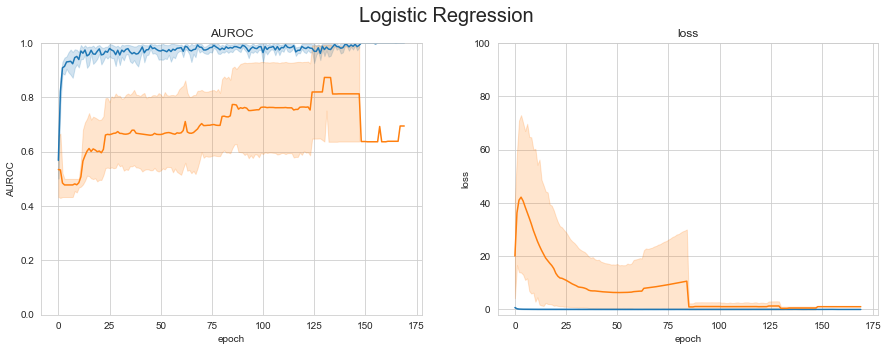

In [19]:
#eval_df_trace_folds.to_csv(work_dir+'/eval_mtrx.csv', index=False)
#data = pd.read_csv(work_dir+'/eval_mtrx.csv')
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Logistic Regression', fontsize=20)
axs = axs.flatten()
mtrx = 'AUROC'
sns.lineplot(x='epoch',y=mtrx, data=data, ax=axs[0])
sns.lineplot(x='epoch',y='val_'+mtrx, data=data, ax=axs[0])
axs[0].set_ylabel(mtrx)
axs[0].set_ylim(0,1)
axs[0].set_title(mtrx)
mtrx = 'loss'
sns.lineplot(x='epoch',y=mtrx, data=data, ax=axs[1])
sns.lineplot(x='epoch',y='val_'+mtrx, data=data, ax=axs[1])
axs[1].set_ylabel(mtrx)
axs[1].set_ylim(-2,100)
axs[1].set_title(mtrx)
plt.show();